In [1]:
from project_lib.genotype_simulation import *
from project_lib.stat_functions import *

C:\Users\PHLUP\miniconda3\envs\masterarbeit\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:158: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.head(1) - 1), rate=0
C:\Users\PHLUP\miniconda3\envs\masterarbeit\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:161: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.tail(1) + 1), rate=0


In [7]:
#read genetic map
genmap = pd.read_csv("data/sim_data/B73_genmap.csv")
#read parent genotypes
parent_genos = pd.read_csv("data/sim_data/NAM_parent_genos.csv")
#read reference allele
ref_allele = pd.read_csv("data/sim_data/B73_alleles.csv")

In [9]:
genmap_mean = genmap

In [11]:
genmap_mean["Rate(cM/Mb)"] = genmap["Rate(cM/Mb)"].mean()

In [12]:
genmap_mean

,Marker,Chromosome,Position(bp),Rate(cM/Mb),Map(cM)
0,PZA01271.1,1,1947984,1.274886,0.0
1,PZA03613.1,1,2914171,1.274886,0.9
2,PZA02129.1,1,3706018,1.274886,3.7
3,PZA02032.1,1,4490461,1.274886,5.1
4,PHM2244.142,1,5562502,1.274886,9.7
...,...,...,...,...,...
969,PHM5435.25,10,144239494,1.274886,82.2
970,PZA01073.1,10,144549995,1.274886,83.2
971,PZA01001.2,10,146538889,1.274886,91.0
972,PZA02578.1,10,146553963,1.274886,91.2


In [8]:
genmap["Rate(cM/Mb)"].mean() 

1.2748863074557677

In [16]:
for i in range(0,26):
    sim_add = pd.read_csv("../sim_output/additive_encoding/")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [4]:
founders = parent_genos["RIL"]

In [5]:
founder_pairs = [(founders[0], non_b73) for non_b73 in founders[1:]]

In [6]:
founder_pairs

[('B73', 'B97'),
 ('B73', 'CML103'),
 ('B73', 'CML228'),
 ('B73', 'CML247'),
 ('B73', 'CML277'),
 ('B73', 'CML322'),
 ('B73', 'CML333'),
 ('B73', 'CML52'),
 ('B73', 'CML69'),
 ('B73', 'Hp301'),
 ('B73', 'IL14H'),
 ('B73', 'Ki11'),
 ('B73', 'Ki3'),
 ('B73', 'Ky21'),
 ('B73', 'M162W'),
 ('B73', 'M37W'),
 ('B73', 'Mo17'),
 ('B73', 'Mo18W'),
 ('B73', 'MS71'),
 ('B73', 'NC350'),
 ('B73', 'NC358'),
 ('B73', 'Oh43'),
 ('B73', 'Oh7B'),
 ('B73', 'P39'),
 ('B73', 'Tx303'),
 ('B73', 'Tzi8')]

In [80]:
parent_genos

,RIL,an1.5,fea2.3,lac1.3,PHM10225.15,PHM10321.11,PHM10404.8,PHM11114.7,PHM11226.13,PHM1218.6,...,PZA03322.3,PZA03322.5,PZA03612.1,PZA03612.2,PZB00901.3,PZB00901.4,PZB01009.1,PZB01009.2,sh1.11,sh1.12
0,B73,A/A,G/G,C/C,G/G,G/G,C/C,T/T,G/G,G/G,...,T/T,G/G,C/C,T/T,G/G,G/G,T/T,G/G,G/G,C/C
1,B97,-/-,G/G,T/T,C/C,C/C,G/G,T/T,G/G,G/G,...,T/T,C/C,C/C,C/C,A/A,G/G,T/T,T/T,A/A,C/C
2,CML103,G/G,A/A,T/T,C/C,G/G,C/C,C/C,T/T,G/G,...,T/T,G/G,T/T,T/T,A/A,T/T,C/C,T/T,A/A,T/T
3,CML228,G/G,A/A,T/T,C/C,C/C,C/C,C/C,T/T,G/G,...,T/T,C/C,C/C,C/C,A/A,T/T,C/C,T/T,G/G,T/T
4,CML247,G/G,A/A,T/T,C/C,G/G,C/C,T/T,G/G,G/G,...,A/A,G/G,C/C,C/C,A/A,T/T,T/T,G/G,A/A,T/T
5,CML277,A/A,A/A,T/T,C/C,G/G,C/C,C/C,T/T,G/G,...,A/A,C/C,-/-,C/C,A/A,T/T,T/T,T/T,A/A,C/C
6,CML322,G/G,A/A,T/T,C/C,G/G,C/C,T/T,T/T,G/G,...,T/T,G/G,T/T,T/T,A/A,T/T,C/C,T/T,A/A,C/C
7,CML333,G/G,A/A,T/T,C/C,G/G,C/C,T/T,G/G,A/A,...,A/A,G/G,T/T,T/T,A/A,G/G,T/T,T/T,G/G,C/C
8,CML52,G/G,A/A,C/C,C/C,G/G,G/G,T/T,T/T,G/G,...,T/T,G/G,T/T,T/T,A/A,T/T,T/T,T/T,A/A,T/T
9,CML69,A/A,A/A,C/C,G/G,G/G,C/C,T/T,G/G,G/G,...,T/T,G/G,T/T,T/T,A/A,G/G,T/T,T/T,A/A,T/T


In [15]:
len(pop_1_genos.index)

194

In [12]:
pop_1_genos

,an1.5,lac1.3,PHM10225.15,PHM10321.11,PHM10404.8,PHM11114.7,PHM11226.13,PHM1218.6,PHM12706.14,PHM12749.13,...,PZB00605.1,PZB01021.1,PZB01062.3,PZB01227.6,PZB01233.1,PZB02058.1,PZD00033.3,umc13.1,vdac1a.1,individual
0,AA,TT,GG,CC,GG,TT,GG,GG,TT,CC,...,GG,TT,TT,AA,AA,TT,GG,GG,GG,0
1,AA,TT,CC,CC,GG,TT,GG,GG,TT,CC,...,AA,TT,TT,AA,AC,TT,GG,GG,GG,1
2,AA,TT,GG,GG,CC,TT,GG,GG,TT,GG,...,GG,CC,TT,AA,AA,TT,GG,GG,CC,2
3,GG,TT,CC,GG,CC,TT,GG,GG,TT,GG,...,AA,TT,TT,AA,CC,TT,TT,AA,CC,3
4,GG,CC,GG,CC,GG,TT,GG,GG,CC,CC,...,GG,TT,TT,AA,AA,TT,GG,AA,GG,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,GG,CC,CC,CC,GG,TT,GG,GG,CC,GG,...,GG,--,TT,AA,CC,TT,TT,AA,GG,189
190,GG,CC,--,CC,GG,TT,GG,GG,CC,CC,...,GG,CC,TT,AA,AA,TT,GG,AA,GG,190
191,AA,CC,GG,GC,GC,TT,GG,GG,TT,GG,...,GG,TT,TT,AA,CC,TT,GG,GG,CC,191
192,AA,TT,GG,--,CC,TT,GG,GG,--,GG,...,GG,TT,TT,AA,AA,TT,GG,GG,GG,192


In [35]:
pop_1_genos_new = pd.read_csv("../data/test_data/pop_01_genos_new.csv")

In [36]:
pop_1_genos_new

,SNP_NAME,an1.5,fea2.3,lac1.3,PHM10225.15,PHM10321.11,PHM10404.8,PHM11114.7,PHM11226.13,PHM1218.6,...,PZA03322.3,PZA03322.5,PZA03612.1,PZA03612.2,PZB00901.3,PZB00901.4,PZB01009.1,PZB01009.2,sh1.11,sh1.12
0,Z001E0001,AA,GG,TT,GG,CC,GG,TT,GG,GG,...,TT,CG,CC,CC,GG,GG,TT,TT,AA,CC
1,Z001E0002,AA,GG,TT,CC,CC,GG,TT,GG,GG,...,TT,CG,CC,TT,AA,GG,TT,GG,AA,CC
2,Z001E0003,AA,GG,TT,GG,GG,CC,TT,GG,GG,...,TT,GG,CC,TT,GG,GG,TT,TT,AA,CC
3,Z001E0004,GG,GG,TT,CC,GG,CC,TT,GG,GG,...,TT,CC,CC,TT,AA,GG,TT,GG,GG,CC
4,Z001E0005,GG,GG,CC,GG,CC,GG,TT,GG,GG,...,TT,CC,CC,CC,AA,GG,TT,--,GG,CC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,Z001E0195,GG,GG,CC,CC,CC,GG,TT,GG,GG,...,TT,CC,CC,TT,AA,GG,TT,TT,AA,CC
190,Z001E0196,GG,GG,CC,--,CC,GG,TT,GG,GG,...,TT,GG,CC,--,GG,GG,TT,GG,AA,CC
191,Z001E0197,AA,GG,CC,GG,GC,GC,TT,GG,GG,...,TT,CC,CC,TT,GG,GG,TT,GG,AA,CC
192,Z001E0198,AA,GG,TT,GG,--,CC,TT,GG,GG,...,TT,GG,CC,CC,AG,GG,TT,GG,AA,CC


In [5]:
#population one genotypes and allele frequencies
pop_1_genos = pd.read_csv("../data/test_data/pop_1_genos.csv")
pop_1_genos = pop_1_genos[pop_1_genos.columns.intersection(genmap["Marker"])]
pop_1_genos["individual"] = [i for i in range(194)]
add_1 = additive_encoding(ref_allele, pop_1_genos)

In [6]:
whole_sim = genotype_simulation(genetic_map = genmap, parent_genos = parent_genos, ref_allele = ref_allele, 
                                founder_list = list(["B73", "B97"]), offspring = 194, selfing_genos = 5)

finished chromsome 1
finished chromsome 2
finished chromsome 3
finished chromsome 4
finished chromsome 5
finished chromsome 6
finished chromsome 7
finished chromsome 8
finished chromsome 9
finished chromsome 10


In [18]:
whole_sim

,individual,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,...,PZA03604.1,PZA00130.9,PZA02969.9,PZA02049.1,PZA00007.1,PHM5435.25,PZA01073.1,PZA01001.2,PZA02578.1,PZA00062.4
0,972,CC,TT,CC,TT,GG,TT,AA,TT,CC,...,CC,CC,TT,CC,AA,GG,GG,CC,TT,TT
1,973,GG,TT,CC,AA,GG,TT,AA,GG,AA,...,CC,CC,TT,CC,AA,GG,GG,CC,TT,TT
2,974,GG,TT,TT,TT,CC,TT,AA,GG,AA,...,CC,CC,TT,CC,AA,GG,GG,CC,TT,TT
3,975,CC,AA,TT,TT,CC,TT,AA,TT,CC,...,CC,CC,TT,CC,AA,GG,GG,CC,TT,TT
4,976,CC,AA,TT,TT,CC,TT,AA,GG,AA,...,TC,CC,CT,GC,CA,AG,AG,CC,TT,TT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,1161,GG,TT,CC,AA,GG,TT,AA,TT,CC,...,CC,CC,TT,CC,AA,GG,GG,CC,TT,TT
190,1162,CC,AA,TT,TT,CC,TT,AA,GG,AA,...,CC,CC,TT,CC,AA,GG,GG,CC,TT,TT
191,1163,CC,AA,TT,TT,CC,TT,AA,GG,AA,...,TT,CC,CC,GG,CC,AA,AA,TT,CC,CC
192,1164,CC,AA,TT,TT,CC,TT,AA,GG,AA,...,TT,CC,TT,CC,AA,GG,GG,CC,TT,TT


In [19]:
whole_add = additive_encoding(ref_allele, whole_sim)

In [20]:
whole_add

SNP,PHM10225.15,PHM10321.11,PHM10404.8,PHM11114.7,PHM11226.13,PHM11985.27,PHM1218.6,PHM12706.14,PHM12749.13,PHM1275.22,...,kip1.3,lac1.3,sh2.21,umc128.2,umc13.1,vdac1a.1,wx1.1,zb21.1,zb27.1,zfl2.9
individual,,,,,,,,,,,,,,,,,,,,,
972,1,-1,-1,-1,-1,-1,-1,-1,1,-1,...,1,-1,1,-1,-1,-1,-1,0,1,-1
973,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,...,1,1,1,-1,-1,-1,1,-1,1,1
974,-1,0,0,-1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,1,0,-1,-1,0,-1
975,1,1,1,-1,-1,-1,-1,-1,0,1,...,-1,-1,0,-1,-1,-1,-1,0,1,1
976,-1,1,1,-1,-1,-1,-1,1,-1,-1,...,1,1,-1,-1,1,-1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,1,1,1,-1,-1,-1,-1,-1,1,1,...,-1,0,1,-1,1,-1,-1,-1,-1,1
1162,1,-1,-1,-1,-1,-1,-1,1,1,-1,...,-1,-1,1,-1,1,-1,1,1,1,-1
1163,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,...,-1,-1,1,-1,-1,-1,1,-1,1,-1


In [12]:
#genmap with 0 recombination
genmap["Rate(cM/Mb)"] = 0

In [13]:
no_sim = genotype_simulation(genetic_map = genmap, parent_genos = parent_genos, ref_allele = ref_allele, 
                                founder_list = list(["B73", "B97"]), offspring = 194, selfing_genos = 5) 

finished chromsome 1
finished chromsome 2
finished chromsome 3
finished chromsome 4
finished chromsome 5
finished chromsome 6
finished chromsome 7
finished chromsome 8
finished chromsome 9
finished chromsome 10


In [7]:
no_sim

,individual,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,...,PZA03604.1,PZA00130.9,PZA02969.9,PZA02049.1,PZA00007.1,PHM5435.25,PZA01073.1,PZA01001.2,PZA02578.1,PZA00062.4
0,972,CC,TT,TT,AA,GG,CC,GG,TT,CC,...,CC,CC,TT,CC,AA,GG,GG,CC,TT,TT
1,973,CC,AA,TT,TT,CC,TT,AA,GT,AC,...,CC,CC,TT,CC,AA,GG,GG,CC,TT,TT
2,974,CC,AA,TT,TT,CC,TT,AA,GG,AA,...,CC,CC,TT,CC,AA,GG,GG,CC,TT,CC
3,975,CC,TT,TT,AA,GG,CC,AA,GG,AA,...,TT,CC,CC,CC,AA,AA,AA,CC,CC,CC
4,976,CC,TT,TT,AA,CC,TT,AA,GG,AA,...,TC,CC,CC,CC,AA,AA,AA,CC,CC,CC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,1161,CC,AA,TT,TT,CC,TT,AA,GG,AA,...,TT,TT,CC,CC,AA,AA,AA,CC,CC,CC
190,1162,CC,AA,TT,TT,CC,TT,GG,TT,CC,...,CC,CC,TT,CC,AA,GG,GG,CC,TT,CC
191,1163,CC,AA,TT,TT,CC,TT,AA,GG,AA,...,TT,CC,CC,CC,AA,AA,AA,CC,CC,TT
192,1164,CC,AA,TT,TT,CC,TT,AA,GG,AA,...,TT,TT,CC,CC,AA,AA,AA,CC,CC,CC


In [18]:
no_add = additive_encoding(ref_allele, no_sim)

In [20]:
no_add.to_csv("data/sim_output/no_add.csv")

In [31]:
def summary_plot(real_additive, sim_additive, founder_list, out_path):
    #get vector of sums of additive encoding for all individuals
    real_sum = real_additive.sum(axis = 1)
    sim_sum = sim_additive.sum(axis = 1)

    #calculate ks test statistic and p value
    ks_statistic, p_value = stats.ks_2samp(real_sum, sim_sum)
    
    #calculate wasserstein distance
    wasserstein_dist = stats.wasserstein_distance(real_sum, sim_sum)

    #compute common bins
    bins = np.linspace(min(np.concatenate([real_sum, sim_sum])), max(np.concatenate([real_sum, sim_sum])), 30)

    #plot histogram and KDEs with ks test and WS dist
    sns.histplot(real_sum, kde = True, label = "Real genotypes", color = "blue", bins = bins, alpha = 0.1)
    sns.histplot(sim_sum, kde = True, label = "Simulated genotypes", color = "orange", bins = bins, alpha = 0.1)
    plt.legend()
    plt.title("Histograms, KDEs and summary statistics of real and simulated genotypes for " + founder_list[0] + "x" + founder_list[1])
    plt.xlabel("Sum of additive encoding per individual")
    plt.text(0.05, 0.95, f'KS Statistic: {ks_statistic:.4f}\nKS Test P-Value: {p_value:.4f}', 
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.text(0.05, 0.85, f'Wasserstein Distance: {wasserstein_dist:.2f}', transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.savefig(out_path, dpi = 300, bbox_inches = "tight")



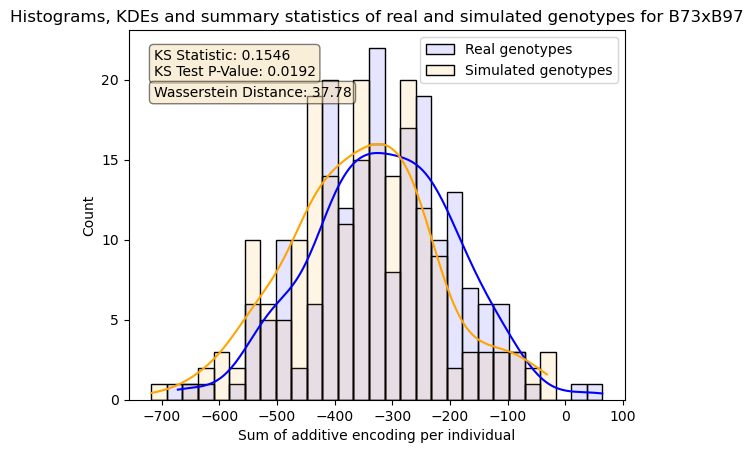

In [32]:
summary_plot(add_1, whole_add, list(["B73", "B97"]),"../plots/sim_output/summary_B73_x.png")

In [25]:
add_1.to_csv("data/sim_output/add_1.csv")

In [ ]:
#genmap with higher recomb rate
genmap["Rate(cM/Mb)"] += 5

In [ ]:
high_sim = genotype_simulation(genetic_map = genmap, parent_genos = parent_genos, ref_allele = ref_allele, 
                                founder_list = list(["B73", "B97"]), offspring = 194, selfing_genos = 5)

In [ ]:
whole_sim

In [34]:
pd.Series(whole_sim.values.flatten().tolist()).value_counts()

CC      49934
GG      45931
TT      45053
AA      43740
--        682
        ...  
1038        1
1039        1
1040        1
1041        1
1165        1
Name: count, Length: 219, dtype: int64

In [ ]:
pd.Series(high_sim.values.flatten().tolist()).value_counts()

In [ ]:
whole_sim.sum(axis = 1).mean()

In [ ]:
high_sim.sum(axis = 1).mean()

In [ ]:
whole_sim.sum(axis = 1).var()

In [ ]:
high_sim.sum(axis = 1).var()

In [27]:
#collect genotypes of replicates
geno_collect = pd.DataFrame({"genotype" : pd.Series(["AA", "GG", "TT", "CC", "--", "TC", "CT", "GA", "AG", "CG", "GC", "GT", "TG", "AC", "CA", "AT", "TA"])})
for i in range(0,10):
    whole_sim = genotype_simulation(genetic_map = genmap, parent_genos = parent_genos, ref_allele = ref_allele, 
                                founder_list = list(["B73", "B97"]), offspring = 194, selfing_genos = 5)
    geno_counts = pd.Series(whole_sim.drop(columns = ["individual"]).values.flatten().tolist()).value_counts().reset_index()
    geno_counts = geno_counts.rename(columns={"index":"genotype", "count":"count"+"_"+str(i)})
    geno_collect = pd.merge(geno_collect, geno_counts, on = "genotype", how = "inner")

#calc sum of heterozygotes and concat with homozygotes
het = pd.DataFrame({"heterozygous":geno_collect[geno_collect["genotype"].isin(["TC", "CT", "GA", "AG", "CG", "GC",
                                                                               "GT", "TG", "AC", "CA", "AT", "TA"])].drop(columns=["genotype"]).sum()})
het.T.reset_index().rename(columns={"index":"genotype"})
geno_collect = pd.concat([geno_collect[geno_collect["genotype"].isin(["AA", "GG", "TT", "CC", "--"])],
                          het.T.reset_index().rename(columns={"index":"genotype"})])

finished chromsome 1
finished chromsome 2
finished chromsome 3
finished chromsome 4
finished chromsome 5
finished chromsome 6
finished chromsome 7
finished chromsome 8
finished chromsome 9
finished chromsome 10
finished chromsome 1
finished chromsome 2
finished chromsome 3
finished chromsome 4
finished chromsome 5
finished chromsome 6
finished chromsome 7
finished chromsome 8
finished chromsome 9
finished chromsome 10
finished chromsome 1
finished chromsome 2
finished chromsome 3
finished chromsome 4
finished chromsome 5
finished chromsome 6
finished chromsome 7
finished chromsome 8
finished chromsome 9
finished chromsome 10
finished chromsome 1
finished chromsome 2
finished chromsome 3
finished chromsome 4
finished chromsome 5
finished chromsome 6
finished chromsome 7
finished chromsome 8
finished chromsome 9
finished chromsome 10
finished chromsome 1
finished chromsome 2
finished chromsome 3
finished chromsome 4
finished chromsome 5
finished chromsome 6
finished chromsome 7
finished 

In [ ]:
#repeat for no recombination model

In [28]:
geno_collect

,genotype,count_0,count_1,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9
0,AA,43630,43344,43801,43546,43768,43836,43681,43890,43766,43740
1,GG,45901,46188,45894,45974,45917,45885,45876,45877,45809,45931
2,TT,44926,45016,44838,44769,44925,44657,44977,44838,44970,45053
3,CC,50113,49977,50049,50066,50184,49790,50071,50268,50201,49934
4,--,647,694,660,683,649,660,651,650,664,682
0,heterozygous,3695,3697,3665,3871,3486,4093,3658,3399,3519,3573


In [ ]:
geno_collect.drop(columns=["genotype"]).mean(axis=1)

In [ ]:
geno_collect.drop(columns=["genotype"]).std(axis=1)

In [30]:
pop_1_genos

,an1.5,lac1.3,PHM10225.15,PHM10321.11,PHM10404.8,PHM11114.7,PHM11226.13,PHM1218.6,PHM12706.14,PHM12749.13,...,PZB00605.1,PZB01021.1,PZB01062.3,PZB01227.6,PZB01233.1,PZB02058.1,PZD00033.3,umc13.1,vdac1a.1,individual
0,AA,TT,GG,CC,GG,TT,GG,GG,TT,CC,...,GG,TT,TT,AA,AA,TT,GG,GG,GG,0
1,AA,TT,CC,CC,GG,TT,GG,GG,TT,CC,...,AA,TT,TT,AA,AC,TT,GG,GG,GG,1
2,AA,TT,GG,GG,CC,TT,GG,GG,TT,GG,...,GG,CC,TT,AA,AA,TT,GG,GG,CC,2
3,GG,TT,CC,GG,CC,TT,GG,GG,TT,GG,...,AA,TT,TT,AA,CC,TT,TT,AA,CC,3
4,GG,CC,GG,CC,GG,TT,GG,GG,CC,CC,...,GG,TT,TT,AA,AA,TT,GG,AA,GG,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,GG,CC,CC,CC,GG,TT,GG,GG,CC,GG,...,GG,--,TT,AA,CC,TT,TT,AA,GG,189
190,GG,CC,--,CC,GG,TT,GG,GG,CC,CC,...,GG,CC,TT,AA,AA,TT,GG,AA,GG,190
191,AA,CC,GG,GC,GC,TT,GG,GG,TT,GG,...,GG,TT,TT,AA,CC,TT,GG,GG,CC,191
192,AA,TT,GG,--,CC,TT,GG,GG,--,GG,...,GG,TT,TT,AA,AA,TT,GG,GG,GG,192


In [33]:
pd.Series(pop_1_genos.drop(columns=["individual"]).values.flatten().tolist()).value_counts()

CC    48141
GG    44253
TT    43374
AA    42202
--     6596
AG     1312
TC     1274
TG      557
AC      443
GC      264
CG      249
TA      158
AT      133
Name: count, dtype: int64

In [ ]:
#get mean and sd + variance of simulation replicates
#mean = []
#var = []
#for i in range(0,10):
#    whole_sim = genotype_simulation(genetic_map = genmap, parent_genos = parent_genos, ref_allele = ref_allele, 
#                                founder_list = list(["B73", "B97"]), offspring = 194, selfing_genos = 5)
#    mean.append(whole_sim.sum(axis = 1).mean())
#    var.append(whole_sim.sum(axis = 1).var())

In [ ]:
np.mean(mean)

In [ ]:
np.std(mean)

In [ ]:
np.mean(var)

In [ ]:
np.std(var)

In [ ]:
print(range(0,195))

In [ ]:
pop_1_genos["individual"] = [i for i in range(194)]

In [ ]:
add_1 = additive_encoding(ref_allele, pop_1_genos)

In [ ]:
add_1.sum(axis = 1).mean()

In [ ]:
add_1.sum(axis = 1).var()

In [ ]:
whole_add = additive_encoding(ref_allele, whole_sim)

In [ ]:
whole_add.sum(axis = 1).mean()

In [ ]:
whole_add.sum(axis = 1).var()

In [ ]:
whole_add.sum(axis = 1).plot.kde()
plt.savefig("plots/sim_add.png")

In [ ]:
add_1.sum(axis = 1).plot.kde()
plt.savefig("plots/real_add_1.png")

In [ ]:
whole_sim.sum(axis = 1).plot.kde()
plt.title("KDE density function of simulated additive genotypes")
plt.savefig("plots/KDE_sim.png")

In [ ]:
stats.kstest(whole_sim.sum(axis = 1), "norm")

In [ ]:
#plt density of additive genotypes
plt.figure(figsize = (8,6))
plt.hist(whole_sim.sum(axis = 1), bins = 20, density = True, alpha = 0.5, color = "b")
plt.title("Histogram of simulated additive genotypes")
plt.savefig("plots/Hist_sim.png")

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
# Reset display options
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [ ]:
pop_1_genos

In [ ]:
pop_1_genos.sum(axis = 1).mean()

In [ ]:
pop_1_genos.sum(axis = 1).var()

In [ ]:
pop_1_genos.sum(axis = 1).plot.kde()
plt.title("KDE density function of original additive genotypes")
plt.savefig("plots/KDE_original.png")

In [ ]:
stats.kstest(pop_1_genos.sum(axis = 1), "norm")

In [ ]:
pop_1_genos.sum(axis = 1).value_counts()

In [ ]:
pd.Series(pop_1_genos.values.flatten().tolist()).value_counts()

In [ ]:
12850 / pd.Series(pop_1_genos.values.flatten().tolist()).value_counts().sum()

In [ ]:
#plt density of additive genotypes
plt.figure(figsize = (8,6))
plt.hist(pop_1_genos.sum(axis = 1), bins = 20, density = True, alpha = 0.5, color = "b")
plt.title("Histogram of original additive genotypes")
plt.savefig("plots/Hist_original.png")

In [ ]:
genmap

In [ ]:
pop_1_genos[genmap["Marker"]]

In [ ]:
whole_sim[genmap["Marker"]].cumsum(axis = 1).mean(axis = 0)

In [ ]:
plt.plot(range(len(whole_sim[genmap["Marker"]].cumsum(axis = 1).mean(axis = 0))), whole_sim[genmap["Marker"]].cumsum(axis = 1).mean(axis = 0))
plt.title("Mean of cumulative sum along the chromosome simulated")

In [ ]:
plt.plot(range(len(whole_sim[genmap["Marker"]].mean(axis = 0))), whole_sim[genmap["Marker"]].mean(axis = 0))
plt.title("Mean along the chromosome simulated")

In [ ]:
whole_sim[genmap["Marker"]].mean(axis = 0)

In [ ]:
whole_sim[genmap["Marker"]].mean(axis = 0).max() - whole_sim[genmap["Marker"]].mean(axis = 0).min()

In [ ]:
plt.plot(range(len(whole_sim[genmap["Marker"]].var(axis = 0))), whole_sim[genmap["Marker"]].var(axis = 0))
plt.title("Variance along the chromosome simulated")

In [ ]:
plt.plot(range(len(whole_sim[genmap["Marker"]].var(axis = 0))), whole_sim[genmap["Marker"]].var(axis = 0))
plt.title("Variance along the chromosome simulated")

In [ ]:
plt.plot(range(len(pop_1_genos[genmap["Marker"]].cumsum(axis = 1).mean(axis = 0))), pop_1_genos[genmap["Marker"]].cumsum(axis = 1).mean(axis = 0))
plt.title("Mean of cumulative sum along the chromosome original")

In [ ]:
plt.plot(range(len(pop_1_genos[genmap["Marker"]].cumsum(axis = 1).var(axis = 0))), pop_1_genos[genmap["Marker"]].cumsum(axis = 1).var(axis = 0))
plt.title("Variance of cumulative sum along the chromosome original")

In [ ]:
pop_1_genos[genmap["Marker"]].mean(axis = 0)

In [ ]:
pop_1_genos[genmap["Marker"]].mean(axis = 0).max() - pop_1_genos[genmap["Marker"]].mean(axis = 0).min()

In [ ]:
plt.plot(range(len(pop_1_genos[genmap["Marker"]].mean(axis = 0))), pop_1_genos[genmap["Marker"]].mean(axis = 0))
plt.title("Mean along the chromosome original")

In [ ]:
plt.plot(range(len(pop_1_genos[genmap["Marker"]].var(axis = 0))), pop_1_genos[genmap["Marker"]].var(axis = 0))
plt.title("Variance along the chromosome original")

In [ ]:
#test with tskit api calls (trees/node queries: parents, is_descendant, _mrca)
#mean recomb tract length
#linkage disequilibrium decay curve

In [ ]:
#calculate rogers and neis distance between real pop and simulated pop
#calculate allele frequencies
def calc_allele_freq(matrix, alleles = 3):
    num_individuals = len(matrix)
    num_snps = len(matrix[0])
    num_alleles = alleles
    allele_frequencies = []

    for j in range(num_snps):
        allele_counts = [0] * num_alleles

        for i in range(num_individuals):
            allele_counts[matrix[i][j]] += 1

        snp_frequencies = [count / num_individuals for count in allele_counts]
        allele_frequencies.extend(snp_frequencies)

    return allele_frequencies

#rogers distance

#neis distance
def neis_distance(X):
    #matrix product of X and its transpose
    d = np.matmul(X, X.T)
    
    #sqrt of diagonal elements
    vec = np.sqrt(np.diag(d))
    
    #Normalize columns of d
    d /= vec[:, np.newaxis]
    
    #Normalize rows of d
    d /= vec
    
    #negative logarithm
    d = -np.log(d)
    
    #todistance matrix
    d = np.asarray(d)
    
    return d

In [ ]:
pop_1_genos_list = pop_1_genos.values.astype(int).tolist()
pop_1_genos_allele_freq = calc_allele_freq(pop_1_genos_list)
#pop_1_genos_allele_freq

In [ ]:
#examples for neis distance and allele frequency functions
X = np.array([[1.0, 3.0, 5.0], [2.0, 4.0, 6.0]])

In [ ]:
X

In [ ]:
neis_distance(X)

In [ ]:
#example (max distance of pop with 4 individauls vs 3 individuals)
matrix_1 = [
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
]
matrix_2 = [
    [1, 1, 1, 1],
    [1, 1, 1, 1],
    [0, 1, 1, 1]
]

freq_1 = calculate_allele_frequency(matrix_1)
freq_2 = calculate_allele_frequency(matrix_2)
print(freq_2)

In [ ]:
X = np.array(list([freq_1, freq_2]))

In [ ]:
neis_distance(X)